In [0]:
from google.colab import files
files.upload()

Saving submission_format.csv to submission_format.csv
Saving test_values.csv to test_values.csv
Saving train_labels.csv to train_labels.csv
Saving train_values.csv to train_values.csv


{'submission_format.csv': b'patient_id,heart_disease_present\nolalu7,0.5\nz9n6mx,0.5\n5k4413,0.5\nmrg7q5,0.5\nuki4do,0.5\nkev1sk,0.5\n9n6let,0.5\njxmtyg,0.5\n51s2ff,0.5\nwi9mcs,0.5\n741h4l,0.5\n1ef64a,0.5\nwa2ix6,0.5\n8167zl,0.5\nn6nldr,0.5\nph85fp,0.5\njfan5p,0.5\n7c4iz1,0.5\nukigml,0.5\nflwvnq,0.5\n5i4fw2,0.5\ndu1pqf,0.5\nvs68qz,0.5\npfyez0,0.5\nazvkw2,0.5\ncird1i,0.5\n3bg32t,0.5\nxzd050,0.5\neyi8et,0.5\nce4x2h,0.5\nsm91nr,0.5\n2il8hh,0.5\nyq9cqg,0.5\n520v5j,0.5\nammgu2,0.5\njix8hj,0.5\nlj5zrq,0.5\n16ceba,0.5\n93w44s,0.5\nbso17z,0.5\nj2w2dc,0.5\n74vwwl,0.5\n0z3fob,0.5\nmr7zyz,0.5\npp5n63,0.5\nj0hix1,0.5\nrn209i,0.5\nnfit8e,0.5\nnb73sy,0.5\ni79t3w,0.5\n9nv2d9,0.5\n2xbeja,0.5\nlwg3wq,0.5\nlrvqwb,0.5\nc6mepo,0.5\n6ued22,0.5\n112e9h,0.5\n8jc7h2,0.5\nunykmj,0.5\n4yeztb,0.5\ntgpy9u,0.5\npf5wp6,0.5\ncj8vj2,0.5\n9w6d9j,0.5\n3l89wd,0.5\n83a6x1,0.5\noua0gr,0.5\nj0hl96,0.5\ndlkzyg,0.5\nr0w4a8,0.5\n46dlca,0.5\n9fkefu,0.5\n6uk6kl,0.5\nc7olxr,0.5\niiyx0q,0.5\n25vetx,0.5\n073vc5,0.5\n18abn0,0.5\nv5

In [0]:
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostClassifier,cv,Pool
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

     |████████████████████████████████| 61.9MB 1.3MB/s 


In [0]:
train_val = pd.read_csv('train_values.csv')
train_lab = pd.read_csv('train_labels.csv')
test_val = pd.read_csv('test_values.csv')
sub = pd.read_csv('submission_format.csv')

In [0]:
train_lab.isnull().sum()

patient_id               0
heart_disease_present    0
dtype: int64

In [0]:
train_val.isnull().sum()

patient_id                              0
slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64

In [0]:
train = train_val.merge(train_lab,on='patient_id',how='outer',left_index=True,right_index=True)

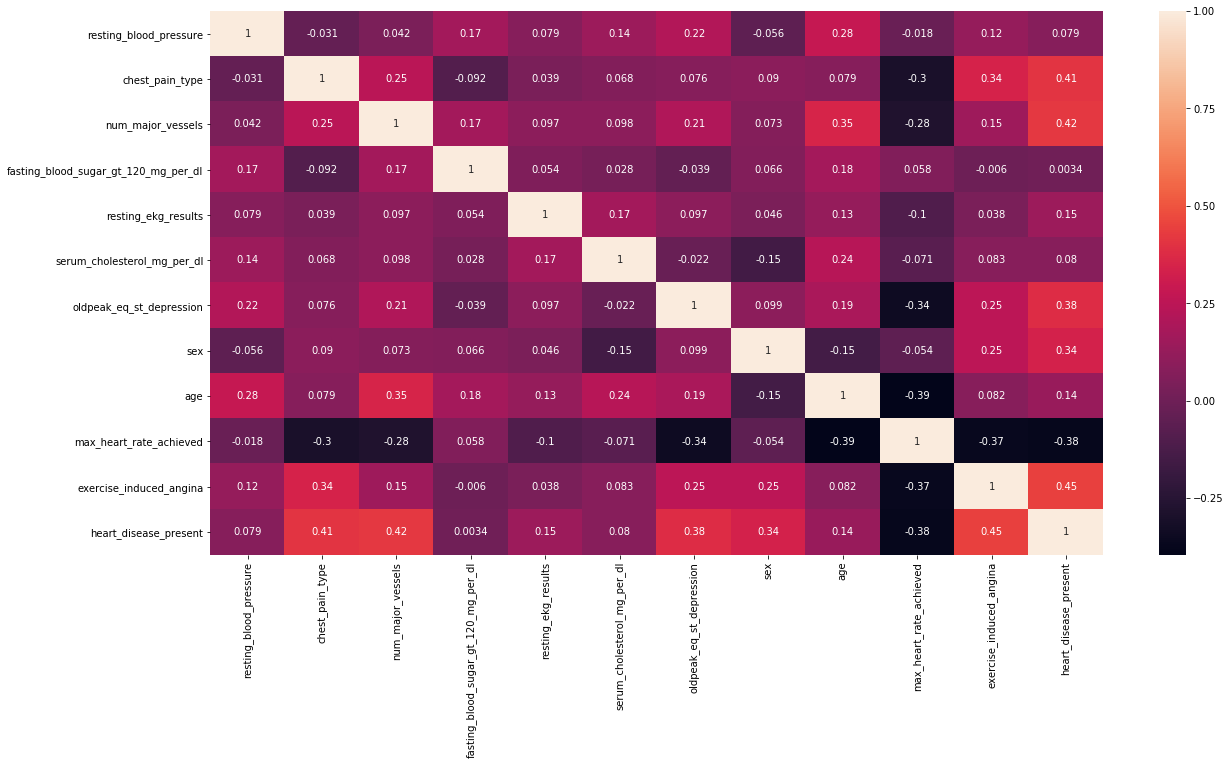

In [0]:
corr = train.corr()
#corr = corr[corr>=0.3]
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True)

In [0]:
train['chest_pain_vessel'] = np.zeros(train.shape[0])
train['chest_pain_vessel'] = train['chest_pain_type'].astype(str) + '_' + train['']

0    3
1    3
2    4
3    4
4    1
Name: chest_pain_type, dtype: int64

In [0]:
train.pop('patient_id')
test_val.pop('patient_id')

In [0]:
train.isnull().sum()

In [0]:
le = LabelEncoder()
for cols in tqdm_notebook(train.columns):
  if train[cols].dtype == 'object':
    train[cols] = le.fit_transform(train[cols])
    

In [0]:
for cols in tqdm_notebook(test_val.columns):
  if test_val[cols].dtype == 'object':
    test_val[cols] = le.fit_transform(test_val[cols])

In [0]:
catParams = {
    'learning_rate':0.1,
    'iterations':10000,
    'custom_metric':'Logloss',
    'loss_function':'CrossEntropy'
}

In [0]:
train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,3,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,-,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


In [0]:
use = ['exercise_induced_angina','chest_pain_type','num_major_vessels','oldpeak_eq_st_depression','sex']

In [0]:
x = train[use]
y = train['heart_disease_present']

In [0]:
test_val = test_val[use]

In [0]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.1)

In [0]:
actual = y_val

In [0]:
train_data = Pool(data = x_train,
                 label = y_train)
val_data = Pool(data = x_val,
               label = y_val)
test_data = Pool(data = test_val)

In [0]:
catModel = CatBoostClassifier(**catParams)
catModel.fit(train_data,verbose=True)

In [0]:
cat_pred = catModel.predict(test_data)

In [0]:
val_pred = catModel.predict_proba(x_val)[:,1]

In [0]:
sub['heart_disease_present'] = lgb_pred
sub['heart_disease_present'] = sub['heart_disease_present'].astype(np.float64)
sub.to_csv('LGBMBoost1.csv',index=False)

In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": 1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [0]:
from sklearn.model_selection import KFold, TimeSeriesSplit

folds = TimeSeriesSplit(n_splits=15)

for fold, (trn_idx, test_idx) in enumerate(folds.split(x, y)):
    print('Training on fold {}'.format(fold + 1))
    trn_data = lgb.Dataset(x.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(x.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)

In [0]:
best_iter = clf.best_iteration
lgbm = lgb.LGBMClassifier(**params, num_boost_round=10)
lgbm.fit(x_train, y_train,verbose=True)

In [0]:
lgb_pred = lgbm.predict_proba(x_val)[:,1]

In [0]:
xgb_params = {
        'n_estimators':100,
        'max_depth':9,
        'learning_rate':0.048,
        'subsample':0.85,
        'colsample_bytree':0.85,
        'missing':-999,
        'reg_alpha':0.15,
        'reg_lamdba':0.85,
        'objective':'reg:logistic'
}

In [0]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
data_vmatrix = xgb.DMatrix(data=x_val,label=y_val)

xgb_reg = xgb.XGBClassifier(**xgb_params)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
xgb_reg.fit(x_train,y_train)
xgb_pred = xgb_reg.predict_proba(x_val)[:,1]

In [0]:
pred = xgb_pred*0.2 + lgb_pred*0.5 + val_pred*0.3

In [0]:
log_loss(actual,pred)

0.537869310077213

In [0]:
sub['heart_disease_present'] = pred
sub.to_csv('combined1.csv',index=False)

ValueError: ignored